# Health Insurance Cross-Sell Prediction
This dataset will be used to predict whether customers with a health insurance policy with a company would also be willing to buy a vehicle insurance policy.
Reference: (Kaggle)https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction

In [195]:
#Import all necessary modules
from collections import defaultdict
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
plt.style.use('ggplot')
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
import scipy.stats as sc
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
%matplotlib inline 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score,accuracy_score,log_loss,confusion_matrix,classification_report,roc_curve
from sklearn.metrics import f1_score, recall_score, precision_recall_curve, precision_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter
from sklearn.model_selection import cross_validate
import category_encoders as ce
from sklearn.metrics import plot_roc_curve

In [196]:
# Read in the training dataset obtained from Kaggle
df = pd.read_csv('train.csv')

In [197]:
#Check first few rows
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [198]:
#Drop id column
df.drop('id',inplace=True,axis=1)

In [199]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [200]:
#Check for null values (No null values in this dataset)
df.info()
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 32.0+ MB


Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [201]:
df['Region_Code'].unique()

array([28.,  3., 11., 41., 33.,  6., 35., 50., 15., 45.,  8., 36., 30.,
       26., 16., 47., 48., 19., 39., 23., 37.,  5., 17.,  2.,  7., 29.,
       46., 27., 25., 13., 18., 20., 49., 22., 44.,  0.,  9., 31., 12.,
       34., 21., 10., 14., 38., 24., 40., 43., 32.,  4., 51., 42.,  1.,
       52.])

0    87.743664
1    12.256336
Name: Response, dtype: float64


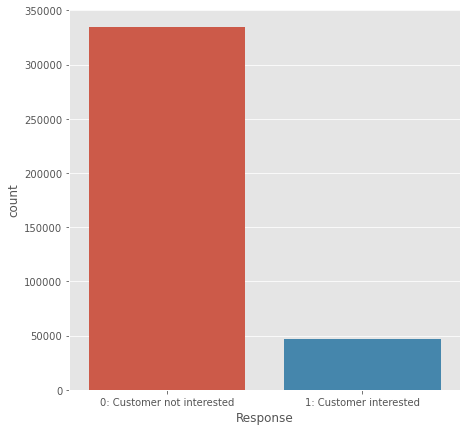

In [202]:
#Check responses for willing/unwilling to buy a vehicle insurance policy
print((df['Response'].value_counts(normalize=True)*100))
plt.figure(figsize=[7,7])
ax = sns.countplot(x='Response',data=df);
ax.set_xticklabels(['0: Customer not interested','1: Customer interested']);

This is an imbalanced class problem, with few people interested in the vehicle insurance policy

In [203]:
#Frequencies of driving license and final responses
pd.pivot_table(df,index='Response',columns=['Driving_License'],aggfunc='size')

Driving_License,0,1
Response,,
0,771,333628
1,41,46669


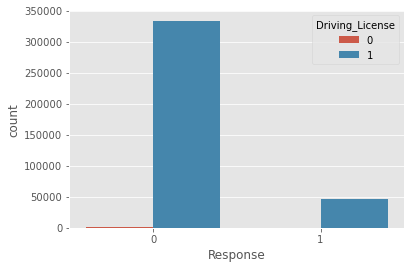

In [204]:
sns.countplot(x='Response',hue='Driving_License',data=df);

In [205]:
#Frequencies of previously insured and final responses
pd.pivot_table(df,index='Response',columns=['Previously_Insured'],aggfunc='size')

Previously_Insured,0,1
Response,,
0,159929,174470
1,46552,158


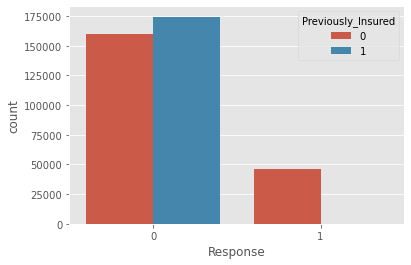

In [206]:
sns.countplot(x='Response',hue='Previously_Insured',data=df);

Most people who are interested in the vehicle insurance policy were not insured previously. Fairly equal split between customers who were/were not insured and not interested in a vehicle insurance policy

In [207]:
#Frequencies of vehicle damage and final responses
pd.pivot_table(df,index='Response',columns=['Vehicle_Damage'],aggfunc='size')

Vehicle_Damage,No,Yes
Response,,
0,187714,146685
1,982,45728


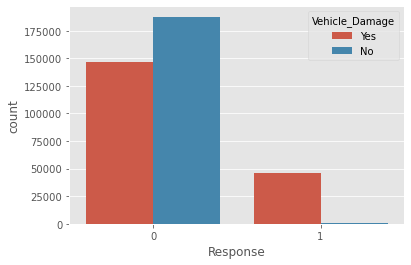

In [208]:
sns.countplot(x='Response',hue='Vehicle_Damage',data=df);

Most people interested in a vehicle insurance policy reported vehicle damage. For those not interested, ~41,000 more people did not have vehicle damage

In [209]:
#Frequencies of vehicle age and final responses
pd.pivot_table(df,index='Response',columns=['Vehicle_Age'],aggfunc='size')

Vehicle_Age,1-2 Year,< 1 Year,> 2 Years
Response,,,
0,165510,157584,11305
1,34806,7202,4702


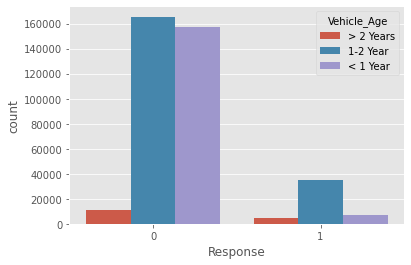

In [210]:
sns.countplot(x='Response',hue='Vehicle_Age',data=df);

Most people who indicated an interest for vehicle insurance have their vehicle age between 1-2 years

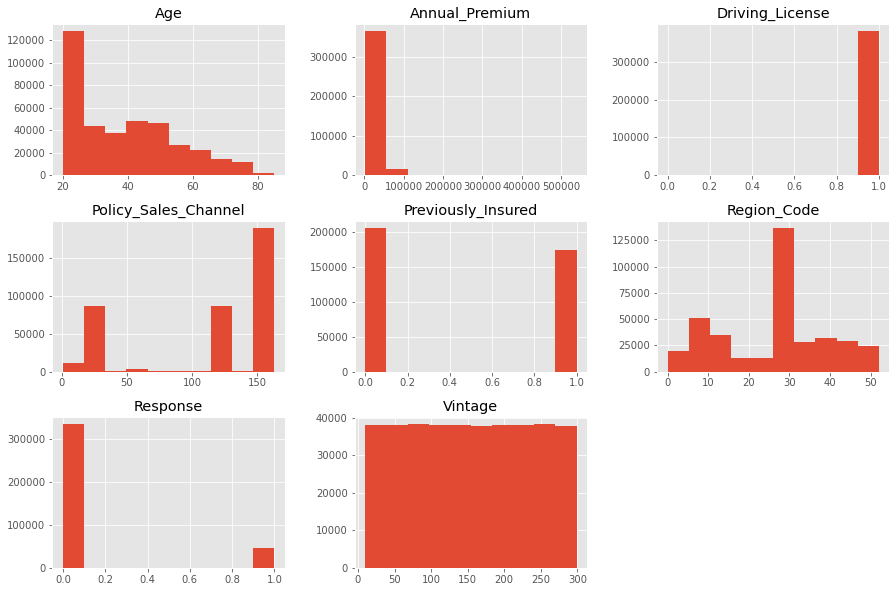

In [211]:
df.hist(figsize=[15,10]);

In [212]:
df.dtypes

Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

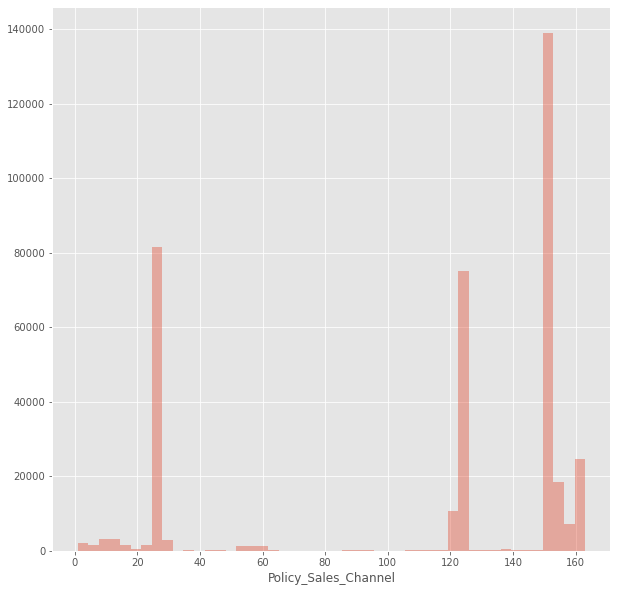

In [213]:
plt.figure(figsize=[10,10])
sns.distplot(df['Policy_Sales_Channel'],kde=False)

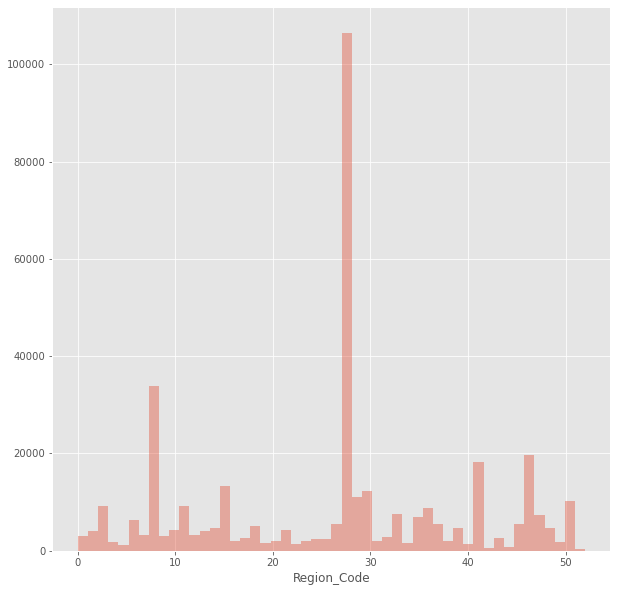

In [214]:
plt.figure(figsize=[10,10])
sns.distplot(df['Region_Code'],kde=False)

In [219]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [221]:
#Weight of Evidence Ratio
cols = ['Policy_Sales_Channel','Region_Code']
woe = ce.WOEEncoder(cols=cols)
woe_fit = woe.fit_transform(df[cols],df['Response']).add_suffix('_woe')
df = pd.concat([df,woe_fit],axis=1)

In [223]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Policy_Sales_Channel_woe,Region_Code_woe
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,0.578246,0.499831
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,0.578246,0.047270
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,0.578246,0.499831
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,-1.555892,-0.093676
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,-1.555892,-0.006989


In [224]:
df.dtypes

Gender                       object
Age                           int64
Driving_License               int64
Region_Code                 float64
Previously_Insured            int64
Vehicle_Age                  object
Vehicle_Damage               object
Annual_Premium              float64
Policy_Sales_Channel        float64
Vintage                       int64
Response                      int64
Policy_Sales_Channel_woe    float64
Region_Code_woe             float64
dtype: object

In [225]:
catf = ['Gender','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage']
catf_lbl = [a+'_lbl' for a in catf]

In [226]:
#Encoding Categorical Data as Labels
for a in catf:
    le = LabelEncoder()
    le.fit(df[a])
    df[a+'_lbl'] = le.transform(df[a])
#One-hot Encoding Categorical Data
#for a in catf:
#    ohe = OneHotEncoder()
#    ohe.fit_transform()

In [227]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Policy_Sales_Channel_woe,Region_Code_woe,Gender_lbl,Driving_License_lbl,Previously_Insured_lbl,Vehicle_Age_lbl,Vehicle_Damage_lbl
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1,0.578246,0.499831,1,1,0,2,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0,0.578246,0.047270,1,1,0,0,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1,0.578246,0.499831,1,1,0,2,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0,-1.555892,-0.093676,1,1,1,1,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0,-1.555892,-0.006989,0,1,1,1,0


In [230]:
df1 = pd.get_dummies(df[catf_lbl].astype(str),drop_first=True)
df1.head()
df1.columns

Index(['Gender_lbl_1', 'Driving_License_lbl_1', 'Previously_Insured_lbl_1',
       'Vehicle_Age_lbl_1', 'Vehicle_Age_lbl_2', 'Vehicle_Damage_lbl_1'],
      dtype='object')

In [231]:
df2 = df.drop(catf,axis=1)
df2 = df2.drop(catf_lbl,axis=1)

In [235]:
df2 = df2.drop(['Region_Code','Policy_Sales_Channel'],axis=1)

In [236]:
df3 = pd.concat((df2,df1),axis=1)

In [237]:
df3.head()

,Age,Annual_Premium,Vintage,Response,Policy_Sales_Channel_woe,Region_Code_woe,Gender_lbl_1,Driving_License_lbl_1,Previously_Insured_lbl_1,Vehicle_Age_lbl_1,Vehicle_Age_lbl_2,Vehicle_Damage_lbl_1
0,44,40454.0,217,1,0.578246,0.499831,1,1,0,0,1,1
1,76,33536.0,183,0,0.578246,0.047270,1,1,0,0,0,0
2,47,38294.0,27,1,0.578246,0.499831,1,1,0,0,1,1
3,21,28619.0,203,0,-1.555892,-0.093676,1,1,1,1,0,0
4,29,27496.0,39,0,-1.555892,-0.006989,0,1,1,1,0,0


In [238]:
xcols = [a for a in df3.columns if a not in ['Response']]
X = df3[xcols]
y = df3['Response']

In [295]:
df3.head()

,Age,Annual_Premium,Vintage,Response,Policy_Sales_Channel_woe,Region_Code_woe,Gender_lbl_1,Driving_License_lbl_1,Previously_Insured_lbl_1,Vehicle_Age_lbl_1,Vehicle_Age_lbl_2,Vehicle_Damage_lbl_1
0,44,40454.0,217,1,0.578246,0.499831,1,1,0,0,1,1
1,76,33536.0,183,0,0.578246,0.047270,1,1,0,0,0,0
2,47,38294.0,27,1,0.578246,0.499831,1,1,0,0,1,1
3,21,28619.0,203,0,-1.555892,-0.093676,1,1,1,1,0,0
4,29,27496.0,39,0,-1.555892,-0.006989,0,1,1,1,0,0


In [330]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,stratify=y)
Counter(y_train)

Counter({1: 35032, 0: 250799})

In [331]:
#Oversampling minority class (1) ; Testing with RandomOverSampler and SMOTE
sm = SMOTE(random_state=1)
X_train,y_train = sm.fit_sample(X_train,y_train)
Counter(y_train)
#ros = RandomOverSampler()
#X_tr_ros, y_tr_ros = ros.fit_resample(X_train,y_train)

Counter({1: 250799, 0: 250799})

In [332]:
mod = RandomForestClassifier(n_estimators=1000,min_samples_split=4,min_samples_leaf=4,verbose=2)
mod.fit(X_train,y_train)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=4,
                       n_estimators=1000)

In [338]:
depth = [estimator.get_depth() for estimator in mod.estimators_]
max(depth)

59

In [323]:
#GridSearchCV with Random Forest
#params = {'n_estimators':[500,800,850],'min_samples_split':[2,5,10],
#          'min_samples_leaf':[2,5,10],'max_features':['sqrt','log2']}       
#rf = RandomForestClassifier()
#grid_cv = GridSearchCV(rf,param_grid = params,scoring='recall',n_jobs=-1,cv=5) 

In [324]:
#model = grid_cv.fit(X_train,y_train)

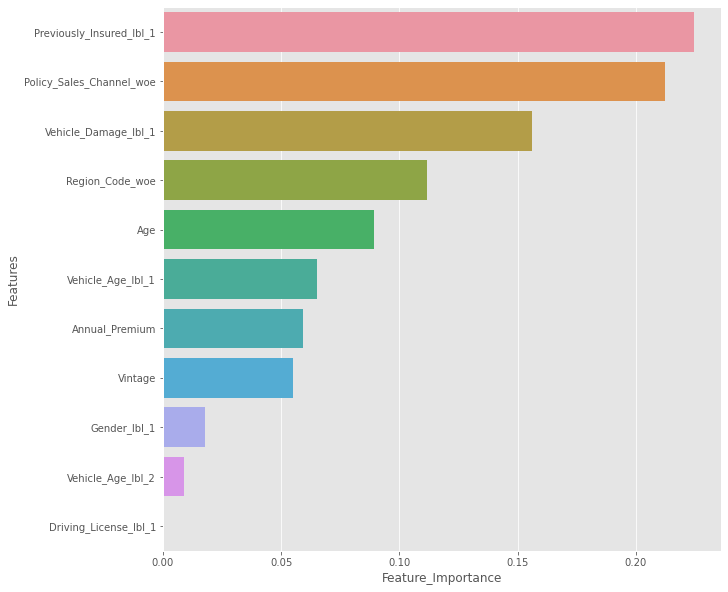

In [333]:
#Feature Importance
feat_imp = np.array(mod.feature_importances_)
feat_names = X_train.columns
feats = pd.DataFrame({'Features':feat_names,'Feature_Importance':feat_imp}).sort_values(by='Feature_Importance',ascending=False)
plt.figure(figsize=[10,10])
sns.barplot(x='Feature_Importance', y='Features',data=feats.nlargest(20,'Feature_Importance'))

In [334]:
y_tr_pred = mod.predict(X_train)
y_tr_pred_prob = mod.predict_proba(X_train)
y_te_pred = mod.predict(X_test)
y_te_pred_prob = mod.predict_proba(X_test)

In [335]:
roc_auc_score(y_train,y_tr_pred_prob[:,1])
#y_te_pred_prob.shape

0.9918815556534312

In [336]:
def metrics(y_true,y_predicted,y_pred_prob):
    sns.heatmap(confusion_matrix(y_true,y_predicted),annot=True,fmt='g',cmap="Blues")
    print('ROC_AUC Score: ' + str(roc_auc_score(y_true,y_pred_prob[:,1])))
    print('Accuracy_Score: ' + str(accuracy_score(y_true,y_predicted)))
    print('F1 Score: ' + str(f1_score(y_true,y_predicted)))
    print('Classification Report: ' + str(classification_report(y_true,y_predicted)))

ROC_AUC Score: 0.837145913347881
Accuracy_Score: 0.825825479124247
F1 Score: 0.36454145127321463
Classification Report:               precision    recall  f1-score   support

           0       0.91      0.88      0.90     83600
           1       0.33      0.41      0.36     11678

    accuracy                           0.83     95278
   macro avg       0.62      0.65      0.63     95278
weighted avg       0.84      0.83      0.83     95278



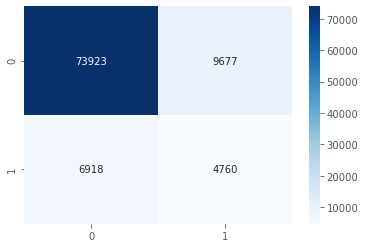

In [337]:
metrics(y_test,y_te_pred,y_te_pred_prob)

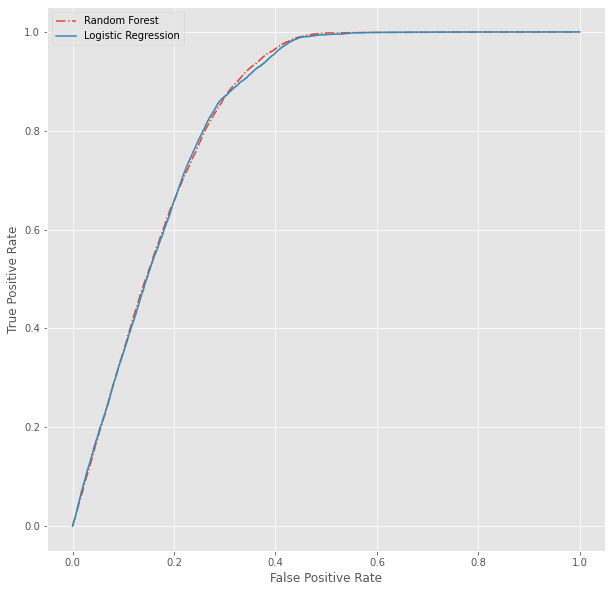

In [349]:
fpr_rf, tpr_rf, th_rf = roc_curve(y_test,y_te_pred_prob[:,1])
fpr_log, tpr_log, th_log = roc_curve(y_test,y_te_pred_prob_lg[:,1])
plt.figure(figsize=[10,10])
plt.plot(fpr_rf, tpr_rf, linestyle='-.', label='Random Forest')
plt.plot(fpr_log, tpr_log, linestyle='-', label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

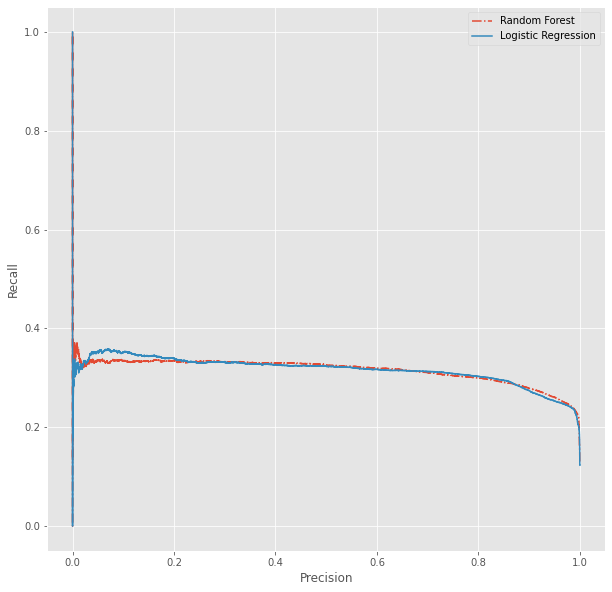

In [350]:
pre_rf, re_rf, the_rf = precision_recall_curve(y_test,y_te_pred_prob[:,1])
pre_log, re_log, the_log = precision_recall_curve(y_test,y_te_pred_prob_lg[:,1])
plt.figure(figsize=[10,10])
plt.plot(re_rf, pre_rf, linestyle='-.', label='Random Forest')
plt.plot(re_log, pre_log, linestyle='-', label='Logistic Regression')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend()

In [341]:
#log_reg = LogisticRegression()
#log_reg.fit(X_train,y_train)
y_tr_pred_lg = log_reg.predict(X_train)
y_tr_pred_prob_lg = log_reg.predict_proba(X_train)
y_te_pred_lg = log_reg.predict(X_test)
y_te_pred_prob_lg = log_reg.predict_proba(X_test

ROC_AUC Score: 0.8361313112989623
Accuracy_Score: 0.7345347299481517
F1 Score: 0.43812062645784733
Classification Report:               precision    recall  f1-score   support

           0       0.97      0.72      0.83     83600
           1       0.30      0.84      0.44     11678

    accuracy                           0.73     95278
   macro avg       0.63      0.78      0.63     95278
weighted avg       0.89      0.73      0.78     95278



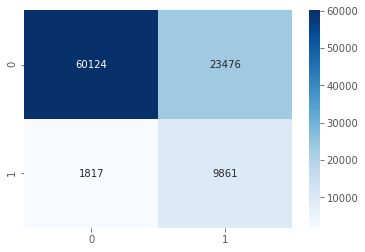

In [342]:
metrics(y_test,y_te_pred_lg,y_te_pred_prob_lg)

In [ ]:
#Grouping Policy Sales Channels categories as 'Others' if their frequency < 5%
#a = pd.DataFrame({'Pcnt_Channel':df['Policy_Sales_Channel'].value_counts(normalize=True)*100}).reset_index()
#a['Chn_Cat'] = np.where(a['Pcnt_Channel']<5,'Other',a['index'].astype(str))
#ch_map = dict(zip(a['index'],a['Chn_Cat']))
#df['Channel_Cat'] = df['Policy_Sales_Channel'].map(ch_map)
#
#Grouping Region codes as 'Others' if their frequency < 5%
#b = pd.DataFrame({'Pcnt_Reg':df['Region_Code'].value_counts(normalize=True)*100}).reset_index()
#b['Reg_Cat'] = np.where(b['Pcnt_Reg']<5,'Other',b['index'].astype(str))
#rg_map = dict(zip(b['index'],b['Reg_Cat']))
#df['Region_Cat'] = df['Region_Code'].map(rg_map)
#
#Categorizing Drivers License and Previously_Insured features
#dl = {1:'Has_DL',0:'No_DL'}
#ins = {1:'Has_VI',0:'No_VI'}
#df['License_Cat'] = df['Driving_License'].map(dl)
#df['Prev_Ins_Cat'] = df['Previously_Insured'].map(ins)
#
#df['Region_Cat'].unique(), df['Channel_Cat'].unique(), df['License_Cat'].unique(), df['Prev_Ins_Cat'].unique()